# Guía de trabajo redes neuronales.

Para esta actividad deben construir una red neuronal como las vistas en clase (no se aceptan otros tipos de redes como las convolucionales o recurrentes). Para esta red neuronal deben realizar una búsqueda de hiperparámetros de tal forma que se maximice el rendimiento del modelo en el conjunto de prueba. Para la búsqueda de hiperparámetros, **se recomienda usar la búsqueda aleatoria.**

## Etapa 1: Carga de los datos.

Antes de comenzar a definir la red neuronal, cargamos la base de datos de interés. Para esta actividad, usaremos la base de datos Fashion-MNIST, la cual consiste en identificar tipos de prendas de vestir https://keras.io/api/datasets/fashion_mnist/. Esta base de datos configura un problema de 10 clases.

## Hecho por: Isabella Ceballos y Juan José Restrepo

# 1) Se cargan las librerías necesarias

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from keras.wrappers.scikit_learn import KerasClassifier

# 2) Se carga la base de datos y se divide en los conjunto de entrenamiento y prueba. Hay 60000 imágenes para el entrenamiento y 10000 en el conjunto de prueba.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


Las imágenes tienen tamaño 28x28. A continuación se muestran algunos ejemplos.


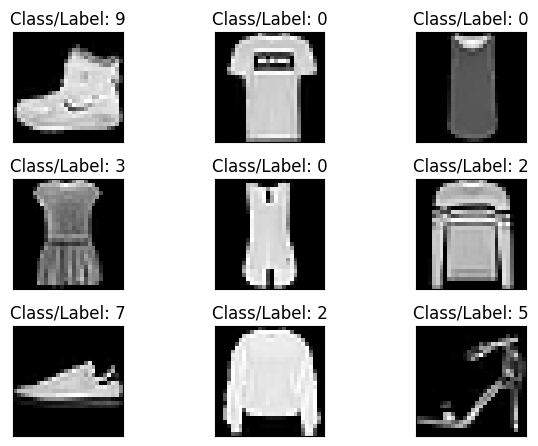

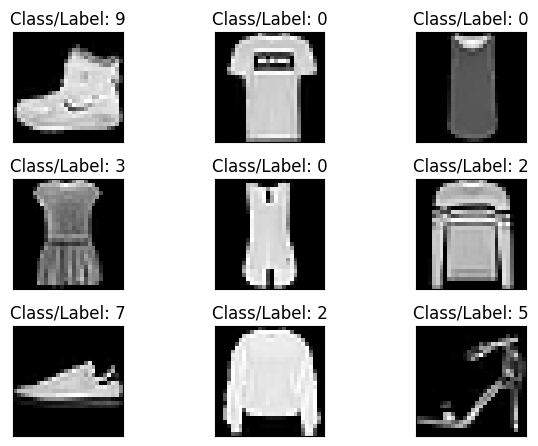

In [ ]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Class/Label: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

# 3) Procedemos a identificar la cantidad y los tipos de clases que existen en el dataset

In [ ]:
clases = np.unique(y_train)
for clase in clases:
    print(clase)
    
num_clases = len(clases)
print('Numero total de clases: ', num_clases)
print('Tipos de clases: ', clases)


0
1
2
3
4
5
6
7
8
9
Numero total de clases:  10
Tipos de clases:  [0 1 2 3 4 5 6 7 8 9]


Como podemos observar, hay 10 diferentes tipos de clases para cada prenda. A continuación, pasamos a identificar el nombre de cada una por su label o etiqueta y a imprimir los 10 primeros elementos con su respectiva Clase/Label

In [ ]:
nombres_clases = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
# Estos labels se obtuvieron de la documentación del dataset

# Tensorflow: https://www.tensorflow.org/datasets/catalog/fashion_mnist
# Github: https://github.com/zalandoresearch/fashion-mnist

for i in range(10):
    label = y_train[i]
    nombre_clase = nombres_clases[label]
    print(f"Label {label}: {nombre_clase}")

Label 9: Ankle boot
Label 0: T-shirt/top
Label 0: T-shirt/top
Label 3: Dress
Label 0: T-shirt/top
Label 2: Pullover
Label 7: Sneaker
Label 2: Pullover
Label 5: Sandal
Label 5: Sandal


# 4) Normalización de Datos



*   Normalizamos los datos de cada imagen para que las imágenes sean compatibles  con las entradas de la red.
*   Hacemos uso de la operación de ***aplastamiento***
(Pasar de 0-255 a 0-1)
*   Recordemos que los valores de 0-255 representan los pixeles, donde:

***0: es negro y 255: blanco***






In [ ]:
def normalizarData(x_train, x_test):
  d1, d2, d3 = x_train.shape
  x_train_flat = x_train.reshape((d1, d2*d3))/255
  d1, d2, d3 = x_test.shape
  x_test_flat = x_test.reshape((d1, d2*d3))/255
  return x_train_flat, x_test_flat

x_train_normalizado, x_test_normalizado = normalizarData(x_train, x_test)

print("x_train_normalizado: ", x_train_normalizado.shape)
print("x_test_normalizado: ", x_test_normalizado.shape)

x_train_normalizado:  (60000, 784)
x_test_normalizado:  (10000, 784)


Como vemos, Se mantienen las mismas 60000 imágenes del entrenaminento y se obtienen 784 atributos luego del proceso de aplastamiento. 28*28=784.

In [ ]:
print("Conjunto datos de entrenamiento Normalizados (X_train)\n")
x_train_normalizado

Conjunto datos de entrenamiento Normalizados (X_train)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print("Conjunto datos de prueba Normalizados (X_test)\n")
x_test_normalizado

Conjunto datos de prueba Normalizados (X_test)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 5) Procedemos a dividir la data de entrenamiento en un  70 % entrenamiento y 30 % de validación

In [ ]:
from sklearn.model_selection import train_test_split
x_train2, x_validation,y_train2,y_validation= train_test_split(x_train_normalizado,y_train,test_size=0.30, random_state=1)
print('x train:',x_train_normalizado.shape)
print(x_train2.shape,x_validation.shape)
print('y train:',y_train.shape)
print(y_train2.shape,y_validation.shape)

x train: (60000, 784)
(42000, 784) (18000, 784)
y train: (60000,)
(42000,) (18000,)


# Etapa 2: Entrenamiento de red neuronal buscando los hiper-parámetros


Se realiza una búsqueda de hiperparámetros de tal forma que se maximice el rendimiento del modelo en el conjunto de prueba. Para la búsqueda de hiperparámetros, usaremos la ***búsqueda aleatoria.***





*   Para la última capa se dejó la activación mediante ***softmax*** ya que tenemos un problema de clasificación de múltiples clases.
*   Para las capas ocultas, se va a implementar activación por relu, ya que se ha comprobado actualmente que es la que más se implementa y la que mejor resultados trae.



In [ ]:
def aleatory_search(model,x_train,y_train,dic):

  rs = RandomizedSearchCV(estimator=model,param_distributions=dic,n_iter=10, n_jobs=-1, cv=5,random_state = 123)# Se define un número máximo de búsqueda
  rs.fit(x_train, y_train)

  print("Best: %f using %s" % (rs.best_score_, rs.best_params_))
  return

# Con una capa de Neurona Oculta

In [ ]:
def create_Model_one(Neuron1):
  #definiendo el modelo
  model = Sequential()
  model.add(Dense(Neuron1, input_shape=(784,), activation='relu')) 

  # Como es un problema de clasificación de múltiples clases, la capa de salida debe tener tantas unidades como clases. 
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
  return model

In [ ]:
parameters = dict(Neuron1 = [128,256,512,1024,2048])

model = KerasClassifier(build_fn=create_Model_one,epochs=30,batch_size=60000,validation_data=(x_validation, y_validation))
aleatory_search(model,x_train2,y_train2,parameters)

<ipython-input-20-3d08160a1ee2>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_Model_one,epochs=30,batch_size=60000,validation_data=(x_validation, y_validation))
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 2.3253 - accuracy: 0.0665 - val_loss: 1.6843 - val_accuracy: 0.4559
Epoch 2/30
1/1 [==============================] - 0s 279ms/step - loss: 1.6797 - accuracy: 0.4573 - val_loss: 1.3612 - val_accuracy: 0.6242
Epoch 3/30
1/1 [==============================] - 0s 306ms/step - loss: 1.3717 - accuracy: 0.6190 - val_loss: 1.2198 - val_accuracy: 0.6098
Epoch 4/30
1/1 [==============================] - 0s 217ms/step - loss: 1.2229 - accuracy: 0.6134 - val_loss: 0.9368 - val_accuracy: 0.6636
Epoch 5/30
1/1 [==============================] - 0s 295ms/step - loss: 0.9370 - accuracy: 0.6621 - val_loss: 0.9326 - val_accuracy: 0.6668
Epoch 6/30
1/1 [==============================] - 0s 235ms/step - loss: 0.9228 - accuracy: 0.6729 - val_loss: 0.8476 - val_accuracy: 0.6996
Epoch 7/30
1/1 [==============================] - 0s 214ms/step - loss: 0.8384 - accuracy: 0.7032 - val_loss: 0.7852 - val_accuracy: 0.7270
Epoch 8/30
1/1 [=======

# Con dos capas de Neurona Oculta

In [ ]:
def create_Model_two(Neuron2):
  #definiendo el modelo
  model = Sequential()
  model.add(Dense(2048, input_shape=(784,), activation='relu')) 
  model.add(Dense(Neuron2, activation='relu'))

  # Como es un problema de clasificación de múltiples clases, la capa de salida debe tener tantas unidades como clases. 
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
  return model

In [ ]:
parameters = dict(Neuron2 = [128,256,512,1024])

model = KerasClassifier(build_fn=create_Model_two,epochs=40,batch_size=60000,validation_data=(x_validation, y_validation))
aleatory_search(model,x_train2,y_train2,parameters)

<ipython-input-15-139ece45f545>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_Model_two,epochs=40,batch_size=60000,validation_data=(x_validation, y_validation))
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 2.3540 - accuracy: 0.0898 - val_loss: 1.7088 - val_accuracy: 0.4019
Epoch 2/40
1/1 [==============================] - 0s 421ms/step - loss: 1.7123 - accuracy: 0.3947 - val_loss: 1.4531 - val_accuracy: 0.6314
Epoch 3/40
1/1 [==============================] - 0s 282ms/step - loss: 1.4314 - accuracy: 0.6318 - val_loss: 1.4768 - val_accuracy: 0.6072
Epoch 4/40
1/1 [==============================] - 0s 279ms/step - loss: 1.4555 - accuracy: 0.6055 - val_loss: 1.2217 - val_accuracy: 0.6267
Epoch 5/40
1/1 [==============================] - 0s 347ms/step - loss: 1.1978 - accuracy: 0.6278 - val_loss: 0.9356 - val_accuracy: 0.6726
Epoch 6/40
1/1 [==============================] - 0s 278ms/step - loss: 0.9203 - accuracy: 0.6746 - val_loss: 0.7868 - val_accuracy: 0.7115
Epoch 7/40
1/1 [==============================] - 0s 303ms/step - loss: 0.7835 - accuracy: 0.7137 - val_loss: 0.8544 - val_accuracy: 0.6851
Epoch 8/40
1/1 [=======

# Con tres capas de Neurona Oculta

In [ ]:
def create_Model_tree(Neuron3):
  #definiendo el modelo
  model = Sequential()
  model.add(Dense(2048, input_shape=(784,), activation='relu')) 
  model.add(Dense(512, activation='relu'))
  model.add(Dense(Neuron3, activation='relu'))

  # Como es un problema de clasificación de múltiples clases, la capa de salida debe tener tantas unidades como clases. 
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
  return model

In [ ]:
parameters = dict(Neuron3 = [128,256,512,1024])

model = KerasClassifier(build_fn=create_Model_tree,epochs=40,batch_size=60000,validation_data=(x_validation, y_validation))
aleatory_search(model,x_train2,y_train2,parameters)

<ipython-input-14-b34331553127>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_Model_tree,epochs=40,batch_size=60000,validation_data=(x_validation, y_validation))
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 2.3098 - accuracy: 0.1678 - val_loss: 1.7686 - val_accuracy: 0.3889
Epoch 2/40
1/1 [==============================] - 0s 433ms/step - loss: 1.7626 - accuracy: 0.3992 - val_loss: 1.4511 - val_accuracy: 0.5272
Epoch 3/40
1/1 [==============================] - 0s 366ms/step - loss: 1.4639 - accuracy: 0.5216 - val_loss: 1.1847 - val_accuracy: 0.6293
Epoch 4/40
1/1 [==============================] - 0s 372ms/step - loss: 1.1816 - accuracy: 0.6343 - val_loss: 1.0374 - val_accuracy: 0.6261
Epoch 5/40
1/1 [==============================] - 0s 359ms/step - loss: 1.0306 - accuracy: 0.6290 - val_loss: 0.9952 - val_accuracy: 0.6928
Epoch 6/40
1/1 [==============================] - 0s 358ms/step - loss: 0.9971 - accuracy: 0.6896 - val_loss: 0.9839 - val_accuracy: 0.6732
Epoch 7/40
1/1 [==============================] - 0s 361ms/step - loss: 0.9876 - accuracy: 0.6690 - val_loss: 0.8601 - val_accuracy: 0.6520
Epoch 8/40
1/1 [=======

# Conclusiones ( PARTE 1 )



*   Si realizamos una red neuronal con una capa oculta y una de salida, se obtuvo un accuracy del 0.83 usando 2048 neuronas en la capa oculta.
*   Si realizamos una red neuronal con 2 capas ocultas, se obtuvo aproximadamente 0.856 usando 2048  neuronas en la primera capa y 512 en la segunda.
*   Si realizamos una red neuronal con 3 capas ocultas, se obtuvo un accuracy del 0.853 usando 2048, 512 y 256 neuronas en cada capa respectivamente.
*   Esto nos permite deducir, que en este caso, puede ser más factible quedarnos con la ***estructura de 2 capas ocultas y una de salida.***


In [ ]:
from tensorflow.keras.optimizers import Adam

def create_Model_two():
  #definiendo el modelo
  model = Sequential()
  model.add(Dense(2048, input_shape=(784,), activation='relu')) 
  model.add(Dense(512, activation='relu'))

  # Como es un problema de clasificación de múltiples clases, la capa de salida debe tener tantas unidades como clases. 
  model.add(Dense(10, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy', optimizer= 'Adam', metrics=['accuracy'])
    
  return model

In [ ]:
parameters = dict(epochs=[40,50,60])

model = KerasClassifier(build_fn=create_Model_two,batch_size=60000,validation_data=(x_validation, y_validation))
aleatory_search(model,x_train2,y_train2,parameters)

<ipython-input-40-9a9f25f84777>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_Model_two,batch_size=60000,validation_data=(x_validation, y_validation))
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Epoch 1/60
1/1 [==============================] - 2s 2s/step - loss: 2.3752 - accuracy: 0.0408 - val_loss: 1.8043 - val_accuracy: 0.2424
Epoch 2/60
1/1 [==============================] - 0s 384ms/step - loss: 1.8006 - accuracy: 0.2404 - val_loss: 1.4598 - val_accuracy: 0.6089
Epoch 3/60
1/1 [==============================] - 0s 356ms/step - loss: 1.4566 - accuracy: 0.6104 - val_loss: 1.3974 - val_accuracy: 0.6177
Epoch 4/60
1/1 [==============================] - 0s 278ms/step - loss: 1.4032 - accuracy: 0.6175 - val_loss: 1.1881 - val_accuracy: 0.6368
Epoch 5/60
1/1 [==============================] - 0s 282ms/step - loss: 1.1815 - accuracy: 0.6447 - val_loss: 0.8663 - val_accuracy: 0.6952
Epoch 6/60
1/1 [==============================] - 0s 366ms/step - loss: 0.8604 - accuracy: 0.6979 - val_loss: 0.8841 - val_accuracy: 0.6758
Epoch 7/60
1/1 [==============================] - 0s 362ms/step - loss: 0.8808 - accuracy: 0.6830 - val_loss: 0.8159 - val_accuracy: 0.7106
Epoch 8/60
1/1 [=======

# Conclusiones ( PARTE 2 )

Al variar las épocas, nos damos cuenta que trae mejor resultado implementar 60 épocas. Pero eso se puede dar, dado que entre más épocas hay, mayor es la etapa o tiempo de entrenamiento. Por ende, el modelo tiende a aprender un poco más al incrementar la épocas.



*   Si se compara con las 40 épocas implementadas anteriormente, de 0.856 pasa a 0.868, eso quiere decir que incrementó un 1.38 % al incrementar 20 épocas más.
*   En este caso, se debe evaluar el costo de tiempo de ejecución y gasto computacional vs el aprendizaje del modelo.


